In [52]:
import torch
from torch import optim

def inverted_pendulum_linear(x, u, m=0.2, M=1.0, L=0.5, g=9.81):
    A = torch.tensor([
        [0, 1, 0, 0],
        [0, 0, (m * g) / M, 0],
        [0, 0, 0, 1],
        [0, 0, ((M + m) * g) / (M * L), 0]
    ])
    
    B = torch.tensor([[0, 1 / M, 0, 1 / (M * L)]]).T

    # Compute the state derivatives
    state_dot = torch.matmul(A, x) + torch.matmul(B, u)

    return state_dot

def simulate_inverted_pendulum_MPC(
    initial_state,
    target_state,
    dt,
    t_end,
    horizon=10,
    m=0.2,
    M=1.0,
    L=0.5,
    g=9.81):
    
    state = initial_state.detach()
    error = target_state[2] - state[2]
    error_intg = error.detach()
    
    states, us, errors = [], [], []  # Store states for plotting or analysis
    time = torch.arange(0, t_end, dt)
    for t in time:
        error = target_state[2] - state[2]
        u = torch.zeros(horizon, 1, requires_grad=True)
        optimizer = optim.Adam([u], lr = 0.1)
        
        # Optimize control input
        for _ in range(100):
            state_pred = state.clone()
            cost = torch.tensor(0)
            for i in range(horizon):
                state_dot = inverted_pendulum_linear(state_pred, u[i:i+1])
                state_pred = state_pred.clone() + dt * state_dot
                cost = cost + ((state_pred[2] - target_state[2])**2)
                
            # Perform optimization step
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        
        state_dot = inverted_pendulum_linear(state, u[0:1], m, M, L, g)
        state_next = state + state_dot * dt
        error_next = target_state[2] - state_next[2]
        
        state = state_next.detach()
        error = error_next.detach()
        
        states.append(state.detach())
        us.append(u.detach())
        errors.append(error.detach())

    return torch.stack(states), torch.stack(us), torch.stack(errors), time

In [ ]:
dt, t_end, n = 0.01, 2, 1

initial_state = torch.tensor([[0.0, 0.0, 0.2, 0.0] for _ in range(n)]).T
target_state = torch.tensor([[0.0, 0.0, 0.0, 0.0] for _ in range(n)]).T

states, us, errors, time = simulate_inverted_pendulum_MPC(
    initial_state,
    target_state,
    dt,
    t_end)

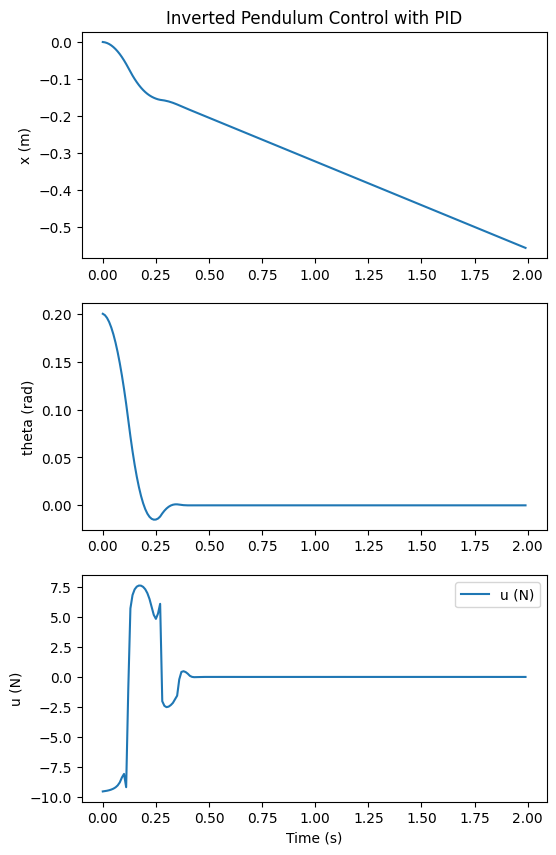

In [57]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.title("Inverted Pendulum Control with PID")
plt.plot(time, states[:, 0, 0], label="Cart Position (x)")
plt.ylabel("x (m)")
plt.subplot(3, 1, 2)
plt.plot(time, states[:, 2], 0, label="Pendulum Angle (theta)")
plt.ylabel("theta (rad)")
plt.subplot(3, 1, 3)
plt.plot(time, us[:, 0], label="u (N)")
plt.ylabel("u (N)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()